# The House Price Prediction
## Team 4: Vicky Van Der Wagt, Halee Staggs, Bethany Wang

Changes 11/19/22
    
*  Inserted data cleaning setps
* Although earlier we talked about replacing missing values with item that correlates to it the most, after looking at graphs, they do not have clear linear relationships. Therefore, I used the averages for now. Will read more projects to see what else they did. 
* Also added discretization (5 categories for longitude, 3 categories for latitude). Then added a loc_cat column (location category) which has the concatenated values. Clear relationship between loc_cat and price
* For duplicate ids, removed the oldest entry and only kept the most recent one. 
* Removed outliers using quartiles in iqr for sqft_living and sqft_lot since those had the most extreme values. Also concluded the 33 bedroom entry was a mistake, as the square footage was less than 2000(definitely could not fit 33 bedrooms). Therefore, replaced it same method as other bedrooms (with average bedrooms). 
* Holding off on deleting most columns until we decide what is relevant to our models

Vicky to do (feel free to add if you find more that needs cleaning)
* Write introduction
* Investigate what other people did to fill in missing bedrooms, bathrooms, sqft living

## 1. Introduction

## 2. Data Importing and Cleaning

* Import dataset and describe characteristics such as dimensions, data types, file types, and import methods used
* Clean, wrangle, and handle missing data
* Transform data appropriately using techniques such as aggregation, normalization, and feature construction
* Reduce redundant data and perform need-based discretization

In [228]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats

### Import data, data characteristics

In [262]:
dataset = pd.read_csv("house_sales.csv")
dataset.shape

(21613, 21)

In [230]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       20479 non-null  float64
 4   bathrooms      20545 non-null  float64
 5   sqft_living    20503 non-null  float64
 6   sqft_lot       20569 non-null  float64
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [231]:
print(dataset)

               id             date     price  bedrooms  bathrooms  \
0      7129300520  20141013T000000  221900.0       3.0       1.00   
1      6414100192  20141209T000000  538000.0       3.0       2.25   
2      5631500400  20150225T000000  180000.0       2.0       1.00   
3      2487200875  20141209T000000  604000.0       4.0       3.00   
4      1954400510  20150218T000000  510000.0       3.0       2.00   
...           ...              ...       ...       ...        ...   
21608   263000018  20140521T000000  360000.0       3.0       2.50   
21609  6600060120  20150223T000000  400000.0       4.0       2.50   
21610  1523300141  20140623T000000  402101.0       2.0       0.75   
21611   291310100  20150116T000000  400000.0       3.0       2.50   
21612  1523300157  20141015T000000  325000.0       2.0       0.75   

       sqft_living  sqft_lot  floors  waterfront  view  ...  grade  \
0           1180.0    5650.0     1.0           0     0  ...      7   
1           2570.0    7242.0   

In [233]:
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Clean and Handle Missing Data

#### Clean up date and convert to date_time unit

In [234]:
from datetime import datetime
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y/%m/%d')

#Generate new columns containing the month and the year column

dataset.shape

(21613, 21)

#### Remove values that don't reflect normal houses, that have zero bedrooms or bathrooms

In [235]:
#am also considering filling them out with average, but for now, this. 
dataset = dataset[dataset['bedrooms']!=0]
dataset = dataset[dataset['bathrooms']!=0]

dataset.shape

(21598, 21)

#### Exploring Potential Outliers

In [236]:
dataset.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159800e+04,2.159800e+04,20466.000000,20532.000000,20488.000000,2.055400e+04,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000
mean,4.580272e+09,5.402003e+05,3.374866,2.114395,2081.451679,1.517233e+04,1.494074,0.007547,0.234281,3.409853,7.657885,1788.545976,291.711501,1970.998611,84.460876,98077.950690,47.560097,-122.213971,1986.606584,12758.585934
std,2.876823e+09,3.671254e+05,0.927418,0.767911,914.715052,4.147700e+04,0.539681,0.086547,0.766374,0.650543,1.173181,827.774352,442.662003,29.374971,401.812546,53.512103,0.138550,0.140731,685.217580,27273.846716
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.070275e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,12050.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### Check and Handle Missing Data

In [237]:
dataset.isnull().sum()

id                  0
date                0
price               0
bedrooms         1132
bathrooms        1066
sqft_living      1110
sqft_lot         1044
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [238]:
# A quick way to clean data, will be replaced later
#dataset = houses.dropna()

#Removing houses that have zero bedrooms or bathrooms; does not reflect typical home.

In [239]:
dataset.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016725,0.003604,0.002104,-0.011600,-0.133038,0.018671,-0.002721,0.011557,-0.023865,0.008227,-0.010705,-0.005146,0.021671,-0.016909,-0.008177,-0.001840,0.020539,-0.002670,-0.138567
price,-0.016725,1.000000,0.311332,0.527382,0.701416,0.088651,0.256815,0.266437,0.397319,0.036018,0.667921,0.605356,0.323777,0.053988,0.126416,-0.053433,0.306770,0.022077,0.585247,0.082835
bedrooms,0.003604,0.311332,1.000000,0.515143,0.577770,0.029219,0.180744,-0.004682,0.082702,0.026705,0.359308,0.480370,0.301927,0.157639,0.019604,-0.155659,-0.010572,0.132637,0.394676,0.026786
bathrooms,0.002104,0.527382,0.515143,1.000000,0.755484,0.087544,0.503260,0.068421,0.186794,-0.127720,0.666698,0.686979,0.283769,0.509007,0.049725,-0.206339,0.027286,0.226041,0.570779,0.089769
sqft_living,-0.011600,0.701416,0.577770,0.755484,1.000000,0.169027,0.355364,0.107094,0.284148,-0.060169,0.763903,0.875819,0.432645,0.319931,0.056989,-0.199986,0.050646,0.240451,0.756868,0.182793
sqft_lot,-0.133038,0.088651,0.029219,0.087544,0.169027,1.000000,-0.005285,0.021201,0.074537,-0.009011,0.112864,0.181785,0.015699,0.052015,0.009040,-0.131328,-0.087569,0.230108,0.145270,0.728450
floors,0.018671,0.256815,0.180744,0.503260,0.355364,-0.005285,1.000000,0.023758,0.028826,-0.264104,0.458806,0.524013,-0.245680,0.489209,0.006436,-0.059519,0.049212,0.125853,0.280113,-0.010732
waterfront,-0.002721,0.266437,-0.004682,0.068421,0.107094,0.021201,0.023758,1.000000,0.401971,0.016607,0.082889,0.072111,0.080560,-0.026149,0.092874,0.030274,-0.014308,-0.041908,0.086508,0.030780
view,0.011557,0.397319,0.082702,0.186794,0.284148,0.074537,0.028826,0.401971,1.000000,0.045986,0.251734,0.167621,0.277084,-0.053624,0.103954,0.084628,0.005862,-0.078127,0.280686,0.072900
condition,-0.023865,0.036018,0.026705,-0.127720,-0.060169,-0.009011,-0.264104,0.016607,0.045986,1.000000,-0.146915,-0.158950,0.173816,-0.361612,-0.060795,0.002868,-0.015076,-0.105790,-0.093088,-0.003116


#### Fill in missing values in the sqft_living column 

In [240]:
sqft_above = dataset['sqft_above']
sqft_basement = dataset['sqft_basement']
sqft_living = sqft_above + sqft_basement
dataset.loc[dataset['sqft_living'].isnull(),'sqft_living']=sqft_living

#### Fill in missing values in the bedrooms column

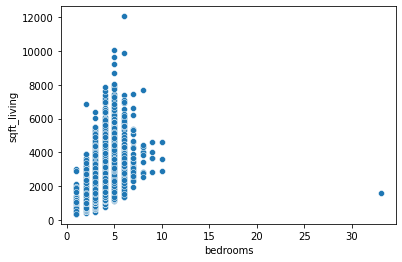

In [241]:
#check which value correlates most (sqft_living)
dataset.corr()

sns.scatterplot(data=dataset, x="bedrooms", y="sqft_living")
#after viewingt the scatterplot, can be seen that the relationship is not quite linear.
#using averages instead.
bedrooms_avg = round(dataset['bedrooms'].mean(),0)
dataset.loc[dataset['bedrooms'].isnull(),'bedrooms']=bedrooms_avg


#### Fill in missing values in the sqft_lot category

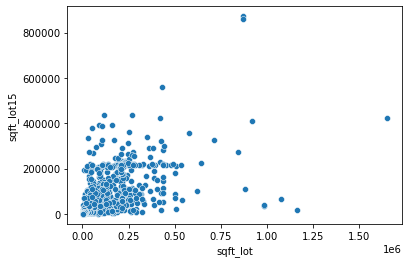

In [242]:
sns.scatterplot(data=dataset, x="sqft_lot", y="sqft_lot15")
#even though high correlation coefficient, no clear relationship. therefore, also using averages.

sqft_lot_avg = round(dataset['sqft_lot'].mean(),0)
dataset.loc[dataset['sqft_lot'].isnull(),'sqft_lot']=sqft_lot_avg

#### Fill in missing values in the bathrooms column

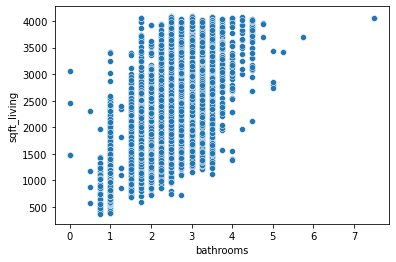

In [268]:
#also used average
sns.scatterplot(data=dataset, x="bathrooms", y="sqft_living")
bathrooms_avg = round(dataset['bathrooms'].mean(),0)
dataset.loc[dataset['bathrooms'].isnull(),'bathrooms']=bathrooms_avg


#### Removing outliers 
* After doing df.describe(), we can see that the biggest outliers are in the bedroom, sqft_lot, and sqft_living categories

In [269]:
#highest bedroom value was 33. After further investigation, looks like data entry mistake. fill with avg
dataset['bedrooms'] = dataset['bedrooms'].replace([33],bedrooms_avg)


In [270]:
#removed outliers with large sqft_lots
q1 = dataset['sqft_lot'].quantile(.25)
q2 = dataset['sqft_lot'].quantile(.5)
q3 = dataset['sqft_lot'].quantile(.75)
q4 = dataset['sqft_lot'].quantile(.1)
iqr = q3 - q1

#instead of doing standard 1.5iqr, did 1.65 so we did not lose too much data
upperlimit = q3 + (1.65*iqr)
lowerlimit = q1 - (1.65*iqr)

dataset = dataset[dataset['sqft_lot']<upperlimit]
#lowerlimit is less than zero so don't need to filter because no occurence of negative values

<AxesSubplot:xlabel='bedrooms', ylabel='sqft_living'>

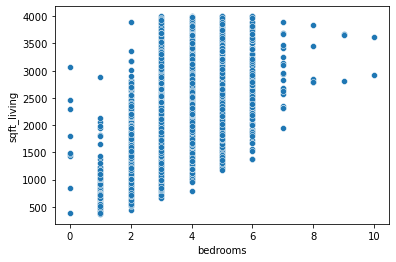

In [271]:
#removed outliers in sqft_living
q1 = dataset['sqft_living'].quantile(.25)
q2 = dataset['sqft_living'].quantile(.5)
q3 = dataset['sqft_living'].quantile(.75)
q4 = dataset['sqft_living'].quantile(.1)

iqr = q3 - q1

#instead of doing standard 1.5iqr, did 1.65 so we did not lose too much data
upperlimit = q3 + (1.6*iqr)
lowerlimit = q1 - (1.6*iqr)

dataset = dataset[dataset['sqft_living']<upperlimit]
sns.scatterplot(data=dataset, x="bedrooms", y="sqft_living")

### Drop redundant data

In [255]:
# To ignore the warning message
warnings.filterwarnings('ignore')

#dropping the earliest entry of each duplicate ID 
dataset.sort_values(by=['id', 'date'], inplace=True)
#keeping the entry with the most recent date
dataset = dataset.drop_duplicates(subset=['id'], keep='last')
#houses.drop(['id'], axis=1, inplace = True)

### Feature Construction and Discretization

#### Add columns for year sold and month sold

In [256]:
dataset['yr_sold'] = pd.DatetimeIndex(dataset['date']).year
dataset['month_sold'] = pd.DatetimeIndex(dataset['date']).month

#### Generate Categories for lat, long, and latitude + longitude

[Text(0, 0, 'south-midwest'),
 Text(1, 0, 'central-midwest'),
 Text(2, 0, 'north-west'),
 Text(3, 0, 'central-west'),
 Text(4, 0, 'north-midwest'),
 Text(5, 0, 'south-west'),
 Text(6, 0, 'north-central'),
 Text(7, 0, 'central-east'),
 Text(8, 0, 'central-mideast'),
 Text(9, 0, 'south-central'),
 Text(10, 0, 'north-east'),
 Text(11, 0, 'central-central'),
 Text(12, 0, 'south-mideast')]

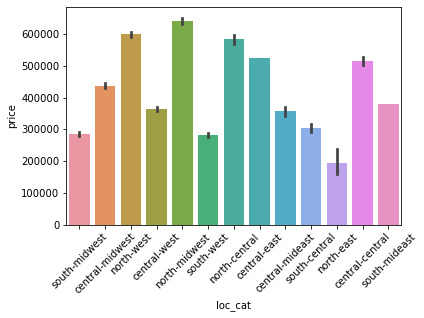

In [257]:
dataset['lat_cat'] = pd.cut(dataset['lat'],3,labels = ['south', 'central', 'north'])
dataset.head()

dataset['long_cat'] = pd.cut(dataset['long'],5,labels = ['west', 'midwest', 'central', 'mideast', 'east'])
dataset.head()

lat_cat = dataset['lat_cat']
long_cat = dataset['long_cat']

#aggregate the latitude and longitude together for a final location category
dataset['loc_cat'] = dataset[['lat_cat', 'long_cat']].agg('-'.join, axis=1)

location_category = dataset['loc_cat']
price = houses['price']
#plot just to see
location_barplot = sns.barplot(x=location_category, y=price)
#makes it so the labels don't run into each other
location_barplot.set_xticklabels(location_barplot.get_xticklabels(), rotation = 45, horizontalalignment = 'center')

## 3. Exploratory Data Analysis and Visualization

* Identify categorical, ordinal, and numerical variables within the data
* Provide measures of centrality and distribution with visualizations
* Diagnose for correlations between variables and determine independent and dependent variables
* Perform exploratory analysis in combination with visualization techniques to discover patterns and features of interest

In [258]:
# Identify categorical, ordinal, and numerical variables within the data

numerical_variables = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 
                       'lat', 'long', 'sqft_living15', 'sqft_lot15']
ordinal_variables = ['condition', 'grade', 'yr_built', 'yr_renovated', 'yr_sold', 'month_sold']
categorical_variables = ['date', 'waterfront', 'view', 'zipcode', 'lat_cat', 'long_cat', 'loc_cat']
print("hi")

hi


### Statistical and Correlation Analysis

In [259]:
# Subset numerical fields
numerical_subset = dataset[numerical_variables]

In [260]:
# Find the statistics for the numerical variables
round(numerical_subset.describe(), 2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15
count,18653.00,18653.00,18653.00,18653.00,18653.00,18653.00,18653.00,18653.00,18653.00,18653.00,18653.00,18653.00
mean,501615.44,3.31,2.05,1951.07,7638.94,1.49,1679.17,271.89,47.56,-122.23,1896.28,7455.77
std,277477.74,0.87,0.70,750.07,3783.72,0.54,699.40,404.47,0.14,0.13,607.21,6449.32
min,78000.00,1.00,0.50,370.00,520.00,1.00,370.00,0.00,47.16,-122.51,460.00,651.00
25%,315000.00,3.00,1.50,1390.00,4997.00,1.00,1160.00,0.00,47.48,-122.34,1450.00,4983.00
50%,435000.00,3.00,2.00,1830.00,7280.00,1.00,1500.00,0.00,47.57,-122.26,1770.00,7202.00
75%,613000.00,4.00,2.50,2410.00,9703.00,2.00,2060.00,530.00,47.68,-122.15,2240.00,9000.00
max,3400000.00,10.00,7.50,4340.00,17739.00,3.50,4340.00,2240.00,47.78,-121.32,5790.00,297514.00


In [261]:
# Find correlation coefficients of among the numerical variables
round(numerical_subset.corr(), 2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15
price,1.00,0.28,0.44,0.63,0.05,0.25,0.51,0.28,0.38,-0.01,0.55,0.04
bedrooms,0.28,1.00,0.48,0.60,0.17,0.16,0.49,0.28,-0.03,0.14,0.38,0.08
bathrooms,0.44,0.48,1.00,0.70,0.00,0.50,0.63,0.22,0.00,0.22,0.52,0.01
sqft_living,0.63,0.60,0.70,1.00,0.21,0.35,0.85,0.39,0.03,0.23,0.74,0.13
sqft_lot,0.05,0.17,0.00,0.21,1.00,-0.29,0.17,0.09,-0.12,0.23,0.25,0.46
floors,0.25,0.16,0.50,0.35,-0.29,1.00,0.54,-0.29,0.03,0.13,0.27,-0.17
sqft_above,0.51,0.49,0.63,0.85,0.17,0.54,1.00,-0.16,-0.04,0.36,0.71,0.12
sqft_basement,0.28,0.28,0.22,0.39,0.09,-0.29,-0.16,1.00,0.13,-0.19,0.14,0.04
lat,0.38,-0.03,0.00,0.03,-0.12,0.03,-0.04,0.13,1.00,-0.16,0.02,-0.09
long,-0.01,0.14,0.22,0.23,0.23,0.13,0.36,-0.19,-0.16,1.00,0.33,0.17


In [ ]:
# Heatmap for correlations
plt.figure(figsize=(12, 8))
plt.title("Heat Map of Correlation Coefficients", fontsize=16)
sns.heatmap(numerical_subset.corr(), cmap = 'coolwarm', fmt = '.1f', linewidths = 1, annot = True)

From the statistical analysis table and the correlation heatmap, we see:
* some redundant variables, such as 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', they can be removed.
* The house with 33 bedrooms should be treated as outlier. Therefore, it can be removed.

### Data Wrangling (Will be merged or replaced)

In [324]:
# Remove some redundant variables
warnings.filterwarnings('ignore')
#houses.drop(['sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'], axis=1, inplace = True)
#numerical_subset.drop(['sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'], axis=1, inplace = True)

# Drop the outlier with the extreme number of bedrooms.tagged this out because we 
#already changed it to 3
#houses.drop(houses[dataset.bedrooms > 20].index, inplace = True)
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.0,2.0,0,0,...,0,1991,0,98002,47.3262,-122.214,2060,7316,2015,4
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.0,1.5,0,0,...,420,1930,0,98168,47.4783,-122.265,1290,10320,2015,4
3557,3600057,2015-03-19,402500.0,4.0,NaN,1650.0,3504.0,1.0,0,0,...,890,1951,2013,98144,47.5803,-122.294,1480,3504,2015,3
18521,3600072,2015-03-30,680000.0,4.0,2.75,2220.0,5310.0,1.0,0,0,...,1050,1951,0,98144,47.5801,-122.294,1540,4200,2015,3
21063,5200087,2014-07-09,487000.0,4.0,2.50,2540.0,5001.0,2.0,0,0,...,0,2005,0,98108,47.5423,-122.302,2360,6834,2014,7


### Adding New Columns

In [325]:
# Add two new columns 'price_per_sqft' and 'price_log' to facilitate analysis
houses['price_per_sqft'] = houses['price'] / houses['sqft_living']
houses['price_log'] = np.log(houses['price'])

numerical_subset['price_per_sqft'] = houses['price'] / houses['sqft_living']
numerical_subset['price_log'] = np.log(houses['price'])
houses.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,price_per_sqft,price_log
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.0,2.0,0,0,...,0,98002,47.3262,-122.214,2060,7316,2015,4,125.000000,12.611538
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.0,1.5,0,0,...,0,98168,47.4783,-122.265,1290,10320,2015,4,164.335664,12.367341
3557,3600057,2015-03-19,402500.0,4.0,NaN,1650.0,3504.0,1.0,0,0,...,2013,98144,47.5803,-122.294,1480,3504,2015,3,243.939394,12.905450
18521,3600072,2015-03-30,680000.0,4.0,2.75,2220.0,5310.0,1.0,0,0,...,0,98144,47.5801,-122.294,1540,4200,2015,3,306.306306,13.429848
21063,5200087,2014-07-09,487000.0,4.0,2.50,2540.0,5001.0,2.0,0,0,...,0,98108,47.5423,-122.302,2360,6834,2014,7,191.732283,13.096019


### Redo Correlation Analysis

<AxesSubplot:title={'center':'Heat Map of Correlation Coefficients'}>

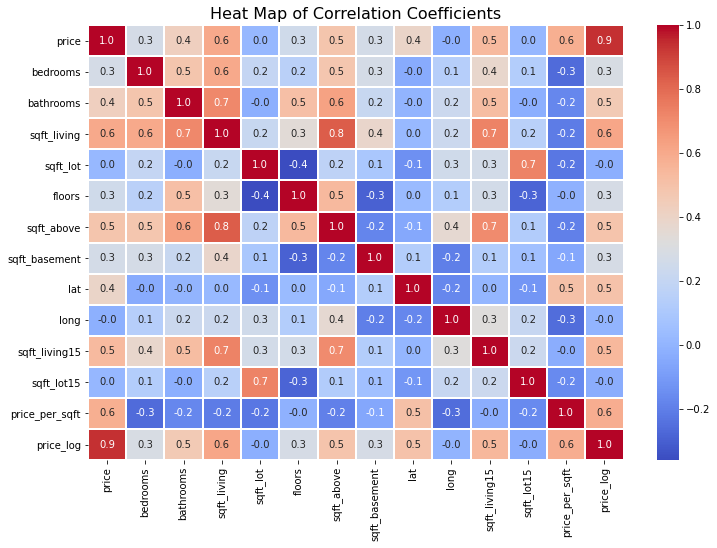

In [326]:
# Heatmap for correlations
plt.figure(figsize=(12, 8))
plt.title("Heat Map of Correlation Coefficients", fontsize=16)
sns.heatmap(numerical_subset.corr(), cmap = 'coolwarm', fmt = '.1f', linewidths = 1, annot = True)

### Histogram Distribution of the Dependent Variable

In [327]:
# Separate Prices into a new variable
prices = dataset['price']

# Define column lists for plotting
bar_cols = ['view', 'waterfront', 'condition', 'grade', 'bedrooms', 'bathrooms']
scatter_cols = ['yr_built', 'yr_renovated', 'sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade', 'floors']
pair_cols = ['sqft_living', 'sqft_lot', 'grade', 'condition']

<AxesSubplot:title={'center':'Distribution of Price Log'}, xlabel='price_log'>

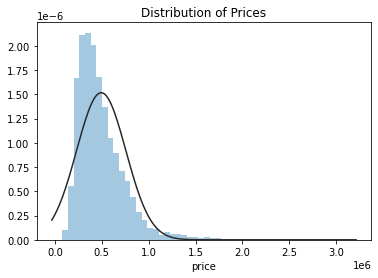

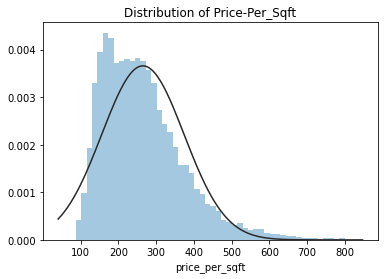

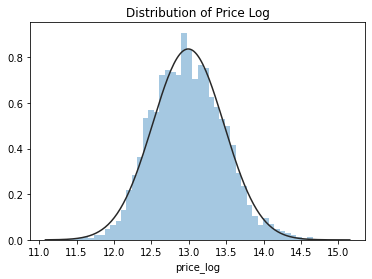

In [328]:
# Display Histogram for Prices
plt.figure(1)
plt.title('Distribution of Prices')
sns.distplot(prices, kde=False, fit=stats.norm)

# Display Histogram for Price-Per-Sqft
plt.figure(2)
plt.title('Distribution of Price-Per_Sqft')
sns.distplot(numerical_subset['price_per_sqft'], kde=False, fit=stats.norm)

# Display Histogram for Price Log
plt.figure(3)
plt.title('Distribution of Price Log')
sns.distplot(houses['price_log'], kde=False, fit=stats.norm)

### Distribution Analysis with Box Plot

<AxesSubplot:title={'center':'Boxplots'}>

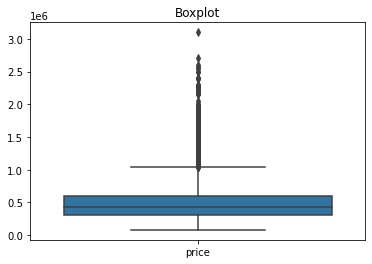

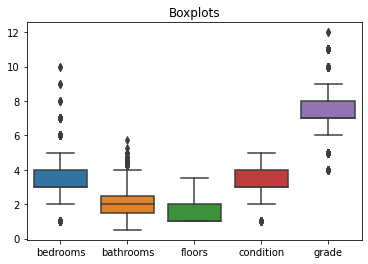

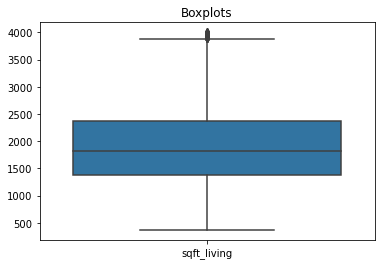

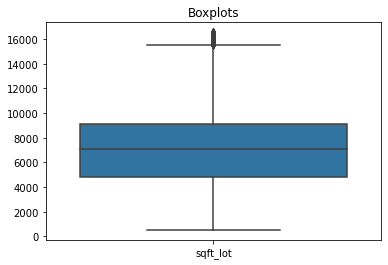

In [329]:
# Create box plots

plt.figure(1)
plt.title('Boxplot')
sns.boxplot(data = dataset[['price']])

plt.figure(2)
plt.title('Boxplots')
sns.boxplot(data = dataset[['bedrooms', 'bathrooms', 'floors', 'condition', 'grade']])

plt.figure(3)
plt.title('Boxplots')
sns.boxplot(data = dataset[['sqft_living']])

plt.figure(4)
plt.title('Boxplots')
sns.boxplot(data = dataset[['sqft_lot']])

### Bar Plots for Categorical and Discrete Variables

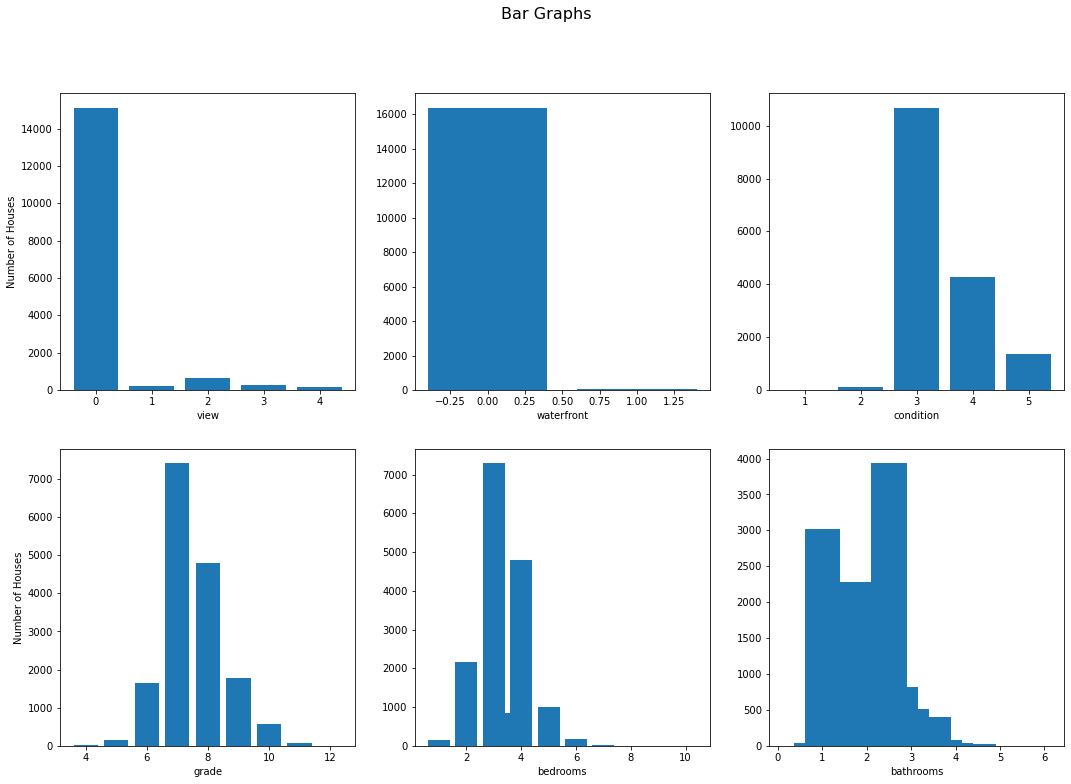

In [333]:
# Create bar plots
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(18,12))
fig.suptitle("Bar Graphs",fontsize=16)

for n in range(len(bar_cols)):
    i = 0 if n < 3 else 1  
    j = n % 3;
    values = dataset[bar_cols[n]].value_counts()
    pd.Series.sort_index(values, inplace=True)
    indexes = list(values.index)
    axes[i][j].bar(indexes, values)
    axes[i][j].set_xlabel(bar_cols[n])
    
axes[0][0].set_ylabel("Number of Houses")
axes[1][0].set_ylabel("Number of Houses")

plt.show()

Text(0.5, 1.0, 'House Distribution by Zipcode')

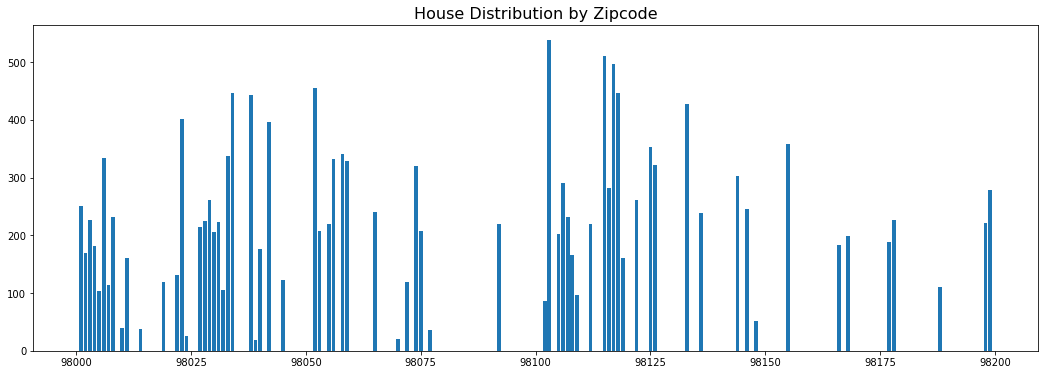

In [334]:
plt.figure(figsize = (18, 6))
values = dataset['zipcode'].value_counts()
pd.Series.sort_index(values, inplace=True)
indexes = list(values.index)
plt.bar(indexes, values)
plt.title("House Distribution by Zipcode", fontsize = 16)

### Scatter Plots for Numerical Variables vs. Price

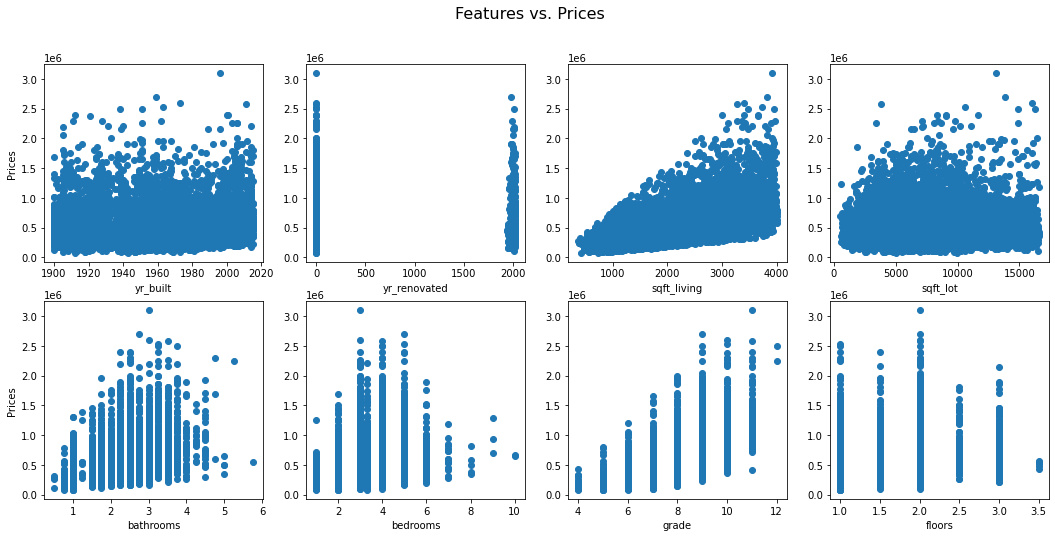

In [336]:
#Create scatter plots
fig,axes = plt.subplots(nrows=2,ncols=4,figsize=(18,8))
fig.suptitle("Features vs. Prices",fontsize=16)

for n in range(len(scatter_cols)):
    i = 0 if n < 4 else 1  
    j = n % 4;
    axes[i][j].scatter(dataset[scatter_cols[n]], prices)
    axes[i][j].set_xlabel(scatter_cols[n])
    
axes[0][0].set_ylabel("Prices")
axes[1][0].set_ylabel("Prices")

plt.show()

### Joint Plot to show Distribution by Latiture and Longitude

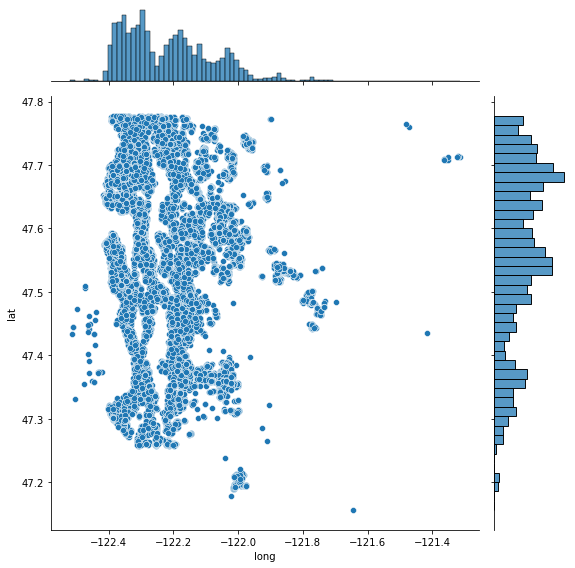

In [68]:
#flipped the lat and long to reperesent map -v 11/19/2022
sns.jointplot(dataset['long'], houses['lat'], size= 8)

## 4. Data Modeling and Analytics

* Determine the need for a supervised or unsupervised learning method and identify dependent and independent variables
* Train, test, and provide accuracy and evaluation metrics for model results


## 5. Conclusion

## References